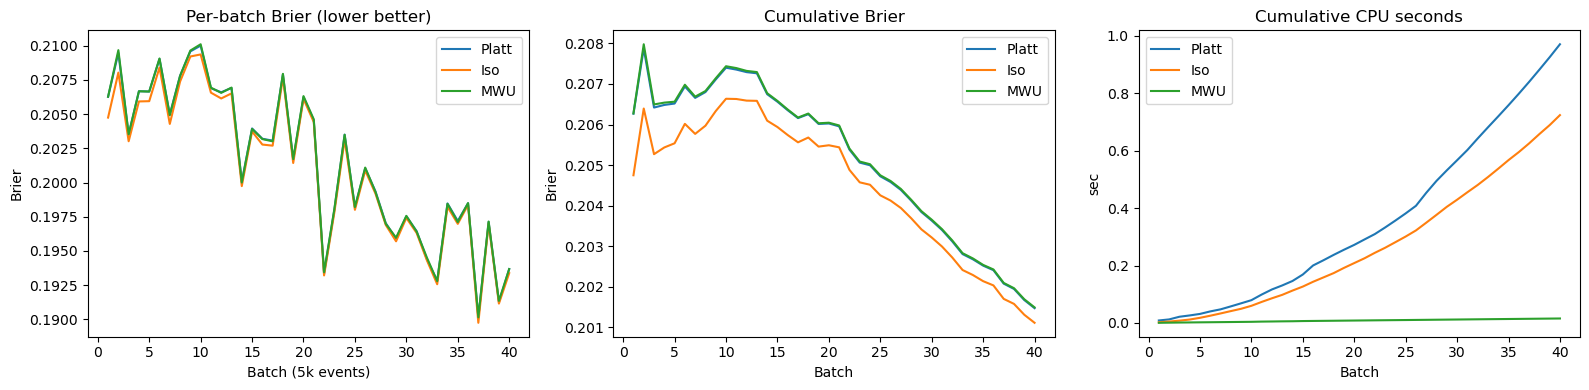

    batch  brier_platt  brier_iso  brier_mwu  time_platt  time_iso  time_mwu
0       1     0.206267   0.204748   0.206275    0.008776  0.002671  0.000680
1       2     0.207875   0.206394   0.207979    0.003655  0.002387  0.000430
2       3     0.206418   0.205268   0.206495    0.009280  0.003055  0.000475
3       4     0.206483   0.205434   0.206540    0.004572  0.003902  0.000350
4       5     0.206517   0.205537   0.206563    0.005276  0.005999  0.000369
5       6     0.206938   0.206016   0.206981    0.008742  0.007327  0.000351
6       7     0.206657   0.205769   0.206687    0.007141  0.007848  0.000356
7       8     0.206800   0.205970   0.206826    0.010363  0.008197  0.000344
8       9     0.207110   0.206331   0.207140    0.010677  0.008080  0.000370
9      10     0.207401   0.206635   0.207437    0.010910  0.010314  0.000363
10     11     0.207355   0.206629   0.207392    0.019607  0.013526  0.000755
11     12     0.207292   0.206589   0.207322    0.017732  0.012690  0.000401

In [35]:
"""
Vectorised MWU vs Platt / Isotonic  ─  Compute‑Accuracy Trade‑off
================================================================
* Streams **200 k events in 40 batches** (5 k each) with monotone drift.
* Compares per‑batch **CPU time** and **Brier score** for:
  1. Platt scaling  (refit logistic each batch)
  2. Isotonic regression (refit PAV each batch)
  3. **Vectorised MWU** bucket calibrator — **one update per bucket**, not per event.

Key: MWU update cost is now **O(#buckets)** instead of O(events).
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

np.random.seed(0)

# ---------- utilities -------------------------------------------------------

def ece(p, y, n_bins=20):
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(p, bins) - 1
    acc, conf, w = [], [], []
    for b in range(n_bins):
        m = idx == b
        if m.any():
            acc.append(y[m].mean()); conf.append(p[m].mean()); w.append(m.mean())
    return np.sum(np.abs(np.array(acc) - np.array(conf)) * np.array(w))

# ---------- drifting stream generator --------------------------------------

def stream(n=200_000, batch=5_000):
    for start in range(0, n, batch):
        size = min(batch, n - start)
        mu = 0.7 * (start / n)      # more drift
        logits = np.random.normal(mu, 1, size)
        p = 1 / (1 + np.exp(-logits))
        yield p, np.random.binomial(1, p)

# ---------- settings and storage -------------------------------------------
B = 100                 # many buckets
bins = np.linspace(0, 1, B + 1)
weights = np.ones(B)    # MWU bias per bucket
eta = 0.1

platt = LogisticRegression(solver="lbfgs", max_iter=200)
iso   = IsotonicRegression(out_of_bounds="clip")

rows = []
P_all, Y_all = [], []
platt_pred, iso_pred, mwu_pred = [], [], []

# ---------- main loop -------------------------------------------------------
for k, (p_raw, y) in enumerate(stream(), 1):
    batch = len(p_raw)
    P_all.append(p_raw); Y_all.append(y)
    P = np.concatenate(P_all); Y = np.concatenate(Y_all)

    # ---- Vectorised MWU bucket update ----
    t0 = time.time()
    bucket_idx = np.digitize(p_raw, bins) - 1
    # Compute calibrated probs with current weights
    bias = weights[bucket_idx]
    p_cal = (bias * p_raw) / (1 - p_raw + bias * p_raw)
    # Bucket‑level statistics
    clicks = np.bincount(bucket_idx, weights=y, minlength=B)
    expos  = np.bincount(bucket_idx, minlength=B)
    expos = np.where(expos==0, 1, expos)  # avoid zero divide
    avg_true = clicks / expos
    avg_pred = (
        np.bincount(bucket_idx, weights=p_cal, minlength=B) / expos
    )
    err = avg_pred - avg_true
    weights *= np.exp(-eta * err)
    weights = np.clip(weights, 1e-3, 1e3)
    t_mwu = time.time() - t0
    mwu_pred.append(p_cal)

    # ---- Platt (refit) ----
    t0 = time.time()
    X_logit = np.log(P / (1 - P)).reshape(-1, 1)
    platt.fit(X_logit, Y)
    p_platt_batch = platt.predict_proba(X_logit[-batch:])[:, 1]
    t_platt = time.time() - t0
    platt_pred.append(p_platt_batch)

    # ---- Isotonic (refit) ----
    t0 = time.time()
    iso.fit(P, Y)
    p_iso_batch = iso.predict(P[-batch:])
    t_iso = time.time() - t0
    iso_pred.append(p_iso_batch)

    # cumulative metrics
    P_platt = np.concatenate(platt_pred)
    P_iso   = np.concatenate(iso_pred)
    P_mwu   = np.concatenate(mwu_pred)

    rows.append({
        "batch": k,
        "brier_platt_batch": brier_score_loss(y, p_platt_batch),
        "brier_iso_batch":   brier_score_loss(y, p_iso_batch),
        "brier_mwu_batch":   brier_score_loss(y, p_cal),
        "brier_platt": brier_score_loss(Y, P_platt),
        "brier_iso":   brier_score_loss(Y, P_iso),
        "brier_mwu":   brier_score_loss(Y, P_mwu),
        "time_platt": t_platt,
        "time_iso":   t_iso,
        "time_mwu":   t_mwu
    })

# ---------- plots -----------------------------------------------------------
df = pd.DataFrame(rows)
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(df.batch, df.brier_platt_batch, label="Platt")
ax[0].plot(df.batch, df.brier_iso_batch,   label="Iso")
ax[0].plot(df.batch, df.brier_mwu_batch,   label="MWU" )
ax[0].set_title("Per‑batch Brier (lower better)")
ax[0].set_xlabel("Batch (5k events)"); ax[0].set_ylabel("Brier")
ax[0].legend()

ax[1].plot(df.batch, df.brier_platt, label="Platt")
ax[1].plot(df.batch, df.brier_iso,   label="Iso")
ax[1].plot(df.batch, df.brier_mwu,   label="MWU")
ax[1].set_title("Cumulative Brier")
ax[1].set_xlabel("Batch"); ax[1].set_ylabel("Brier")
ax[1].legend()

ax[2].plot(df.batch, df.time_platt.cumsum(), label="Platt")
ax[2].plot(df.batch, df.time_iso.cumsum(),   label="Iso")
ax[2].plot(df.batch, df.time_mwu.cumsum(),   label="MWU")
ax[2].set_title("Cumulative CPU seconds")
ax[2].set_xlabel("Batch"); ax[2].set_ylabel("sec")
ax[2].legend()
plt.tight_layout(); plt.show()
            
print(df[["batch", "brier_platt", "brier_iso", "brier_mwu", "time_platt","time_iso","time_mwu"]])

In [36]:
df[["batch", "brier_platt", "brier_iso", "brier_mwu", "time_platt","time_iso","time_mwu"]].describe()

,batch,brier_platt,brier_iso,brier_mwu,time_platt,time_iso,time_mwu
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,20.500000,0.205131,0.204504,0.205159,0.024243,0.018081,0.000392
std,11.690452,0.001896,0.001706,0.001904,0.013326,0.009282,0.000095
min,1.000000,0.201470,0.201110,0.201490,0.003655,0.002387,0.000341
25%,10.750000,0.203572,0.203158,0.203594,0.013193,0.011541,0.000351
50%,20.500000,0.205984,0.205075,0.206003,0.021023,0.017162,0.000357
75%,30.250000,0.206585,0.205811,0.206608,0.038343,0.027016,0.000370
max,40.000000,0.207875,0.206635,0.207979,0.045170,0.034824,0.000755
